*Code 4 (EfficientNetV2-M)*

In [ ]:
# upload kaggle.json
from google.colab import files
files.upload()

In [ ]:
# Kaggle konfiguration
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 1. Kaggle Download & Unzip (automatisch)
import os

DATA_DIR = "/content/datasciencebowl"
TRAIN_DIR = os.path.join(DATA_DIR, "train")

# Kaggle API: Dataset herunterladen
if not os.path.exists("datasciencebowl.zip"):
    !kaggle competitions download -c datasciencebowl --quiet

# Hauptzip entpacken
if not os.path.exists(DATA_DIR):
    !unzip -q datasciencebowl.zip -d datasciencebowl

# Train, Test, SampleSubmission entpacken
!unzip -oq datasciencebowl/train.zip -d datasciencebowl/train
!unzip -oq datasciencebowl/test.zip -d datasciencebowl/test
!unzip -oq datasciencebowl/sampleSubmission.csv.zip -d datasciencebowl

# Doppelten train-Ordner zusammenführen (rsync)
if os.path.exists("datasciencebowl/train/train"):
    !rsync -a --ignore-existing datasciencebowl/train/train/ datasciencebowl/train/
    !rm -r datasciencebowl/train/train

print("Done!")

In [ ]:
# 2. Imports
import copy
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision import transforms
from torchvision.models import (
    efficientnet_v2_m,
    EfficientNet_V2_M_Weights
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [ ]:
# 3. Custom dataset
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, classes=None, transform=None):
        self.samples = []
        if classes is None:
            classes = sorted([
                d for d in os.listdir(root_dir)
                if os.path.isdir(os.path.join(root_dir, d))
            ])
        self.label2idx = {cls: i for i, cls in enumerate(classes)}
        for cls in classes:
            cls_path = os.path.join(root_dir, cls)
            for f in os.listdir(cls_path):
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.samples.append((cls, os.path.join(cls_path, f)))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label, path = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label2idx[label]

In [ ]:
# 4. Filter Classes by Threshold
classes = sorted([
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
])

class_counts = {
    cls: len([
        f for f in os.listdir(os.path.join(TRAIN_DIR, cls))
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ])
    for cls in classes
}

df_counts = pd.DataFrame.from_dict(class_counts, orient="index", columns=["num_images"])
df_counts = df_counts.sort_values("num_images", ascending=False)

threshold = 114
classes_filtered = df_counts[df_counts["num_images"] > threshold].index.tolist()
print(f"Filtered classes: {len(classes_filtered)}")

Filtered classes: 60


In [ ]:
# 5. Compute global mean and std
pixel_sum, pixel_sq_sum, pixel_count = 0, 0, 0
for cls in tqdm(classes_filtered, desc="Calculating mean/std"):
    cls_path = os.path.join(TRAIN_DIR, cls)
    for f in os.listdir(cls_path):
        if f.lower().endswith((".png", ".jpg", ".jpeg")):
            img = np.array(Image.open(os.path.join(cls_path, f)).convert("RGB"), dtype=np.float32)
            pixel_sum += img.sum()
            pixel_sq_sum += (img ** 2).sum()
            pixel_count += img.size

global_mean = pixel_sum / pixel_count
global_std = np.sqrt(pixel_sq_sum / pixel_count - global_mean**2)
print(f"Global mean: {global_mean:.2f}, Global std: {global_std:.2f}")

mean = global_mean / 255.0
std  = global_std / 255.0

Calculating mean/std: 100%|██████████| 60/60 [00:08<00:00,  6.95it/s]

Global mean: 241.34, Global std: 40.29


In [ ]:
# 6. Transformations
IMG_SIZE = 256     # then 320, then 384

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean]*3, std=[std]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean]*3, std=[std]*3)
])

In [ ]:
# 7. Dataset and split
full_dataset = ImageFolderDataset(root_dir=TRAIN_DIR, classes=classes_filtered)

labels = [full_dataset.label2idx[label] for label, _ in full_dataset.samples]
indices = list(range(len(full_dataset)))

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

train_ds = Subset(full_dataset, train_idx)
val_ds   = Subset(full_dataset, val_idx)

train_ds.dataset.transform = train_transform
val_ds.dataset.transform   = val_transform

In [ ]:
# 8. DataLoaders
batch_size = 8   # risk of CUDA out of memory if batch size is too large, start with 8, then 16, then 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# 9. Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

weights = EfficientNet_V2_M_Weights.DEFAULT
model = efficientnet_v2_m(weights=weights)

# Replace classifier head
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, len(classes_filtered))

model.to(device)

#for param in model.features.parameters():   # use if you choose 10b
#    param.requires_grad = False             # use if you choose 10b

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

Using device: cuda
Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth


100%|██████████| 208M/208M [00:01<00:00, 120MB/s]


In [ ]:
# 10a. Training Loop with Early Stopping
epochs = 50
patience = 5

train_losses, val_losses, val_f1_scores = [], [], []
best_f1 = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            running_val_loss += loss.item()
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_f1 = f1_score(all_labels, all_preds, average="macro")
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Macro-F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

model.load_state_dict(best_model_wts)

Epoch 1/50 | Train Loss: 1.3737 | Val Loss: 0.9260 | Val Macro-F1: 0.6587
Epoch 2/50 | Train Loss: 0.8755 | Val Loss: 0.8966 | Val Macro-F1: 0.6775
Epoch 3/50 | Train Loss: 0.7341 | Val Loss: 0.7817 | Val Macro-F1: 0.7284
Epoch 4/50 | Train Loss: 0.6294 | Val Loss: 0.7699 | Val Macro-F1: 0.7240
Epoch 5/50 | Train Loss: 0.5451 | Val Loss: 0.7937 | Val Macro-F1: 0.7210
Epoch 6/50 | Train Loss: 0.4658 | Val Loss: 0.8377 | Val Macro-F1: 0.7268
Epoch 7/50 | Train Loss: 0.3953 | Val Loss: 0.8164 | Val Macro-F1: 0.7500
Epoch 8/50 | Train Loss: 0.3279 | Val Loss: 0.8088 | Val Macro-F1: 0.7450
Epoch 9/50 | Train Loss: 0.2774 | Val Loss: 0.9589 | Val Macro-F1: 0.7194
Epoch 10/50 | Train Loss: 0.2395 | Val Loss: 0.9666 | Val Macro-F1: 0.7405
Epoch 11/50 | Train Loss: 0.2055 | Val Loss: 0.9780 | Val Macro-F1: 0.7307
Epoch 12/50 | Train Loss: 0.1872 | Val Loss: 1.0067 | Val Macro-F1: 0.7390
Early stopping triggered at epoch 12


<All keys matched successfully>

In [ ]:
# 10b. Training Loop with Early Stopping and AMP

import torch
from torch.cuda.amp import autocast, GradScaler

epochs = 50
patience = 5

train_losses, val_losses, val_f1_scores = [], [], []
best_f1 = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0

# Initialize GradScaler for AMP
scaler = GradScaler()

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0

    # Training loop with AMP
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        # Forward pass with autocast for mixed-precision
        with autocast():
            out = model(x)
            loss = criterion(out, y)

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Optimizer step
        scaler.step(optimizer)

        # Update the scale for the next iteration
        scaler.update()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    all_preds, all_labels = [], []

    # Validation loop
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)

            # Forward pass with autocast for mixed-precision
            with autocast():
                out = model(x)
                loss = criterion(out, y)

            running_val_loss += loss.item()
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    val_f1 = f1_score(all_labels, all_preds, average="macro")
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Macro-F1: {val_f1:.4f}")

    # Early Stopping
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model weights after training
model.load_state_dict(best_model_wts)

In [ ]:
# 10c. Training Loop with Early Stopping with backbone freeze
epochs = 50
patience = 5
UNFREEZE_EPOCH = 8

train_losses, val_losses, val_f1_scores = [], [], []
best_f1 = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0

for epoch in range(epochs):

    # Unfreeze backbone
    if epoch == UNFREEZE_EPOCH:
        for param in model.features.parameters():
            param.requires_grad = True

        optimizer = optim.AdamW(
            model.parameters(),
            lr=1e-4,          # lower LR for fine-tuning
            weight_decay=1e-4
        )

        print(f"Backbone unfrozen at epoch {epoch+1}. Fine-tuning entire model.")

    model.train()
    running_train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            running_val_loss += loss.item()
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_f1 = f1_score(all_labels, all_preds, average="macro")
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Macro-F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

model.load_state_dict(best_model_wts)

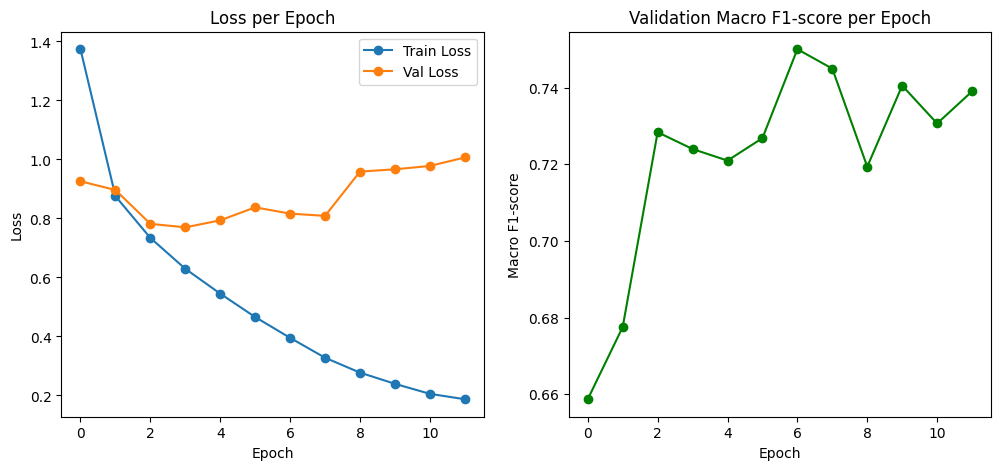

In [ ]:
# 11. Visualization
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o', label='Train Loss')
plt.plot(val_losses, marker='o', label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_f1_scores, marker='o', color='green')
plt.title("Validation Macro F1-score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Macro F1-score")
plt.savefig('F1_score.png', dpi=300)
plt.show()